# Morals of knowledge transfer

I present 3 techniques, accompanied by 3 moral analogies.

Disclaimer: the morals are totally unrelated from the phenomena. (This doesn't make them untrue tho.)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Input, Softmax
from tensorflow.keras import Model

from plot import plot_predictions, plot_images, plot_image
from IPython.core.display import SVG

np.random.seed(420)
tf.random.set_seed(420)

# The dataset

## MNIST

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [3]:
def select_digits(digits=range(10)):
    x_train_selected = x_train[np.in1d(y_train, digits)]
    y_train_selected = y_train[np.in1d(y_train, digits)]
    return (x_train_selected, y_train_selected), (x_test, y_test)

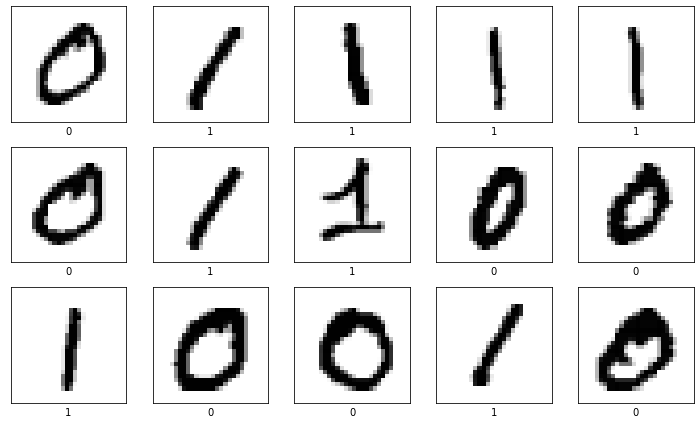

In [5]:
(x_train_selected, y_train_selected), (x_test, y_test) = select_digits([0, 1])

plot_images(x_train_selected, y_train_selected)

# The models

## Teacher

In [6]:
def teacher():
    return tf.keras.models.Sequential([
        Conv2D(32, 3, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10)
    ])

![](teacher.jpg)

## Student

In [7]:
def student():
    return tf.keras.models.Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(10)
    ])

![](student.jpg)

# Knowledge distillaton

## Train teacher

In [8]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()

teacher_model = teacher()
teacher_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train_selected, 
    y_train_selected, 
    test_size=0.3, 
    random_state=42)
teacher_model.fit(x_tr, 
          y_tr, 
          epochs=20, 
          validation_data=[x_val, y_val],
          callbacks=[tf.keras.callbacks.EarlyStopping()])

test_loss, teacher_test_acc = teacher_model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print('\nTest accuracy:', teacher_test_acc)

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 14s 333us/sample - loss: 0.1891 - accuracy: 0.9436 - val_loss: 0.0766 - val_accuracy: 0.9772
Epoch 2/20
42000/42000 [==============================] - 13s 315us/sample - loss: 0.0651 - accuracy: 0.9799 - val_loss: 0.0731 - val_accuracy: 0.9785
Epoch 3/20
42000/42000 [==============================] - 14s 323us/sample - loss: 0.0390 - accuracy: 0.9877 - val_loss: 0.0591 - val_accuracy: 0.9826
Epoch 4/20
42000/42000 [==============================] - 14s 344us/sample - loss: 0.0271 - accuracy: 0.9910 - val_loss: 0.0605 - val_accuracy: 0.9825
10000/10000 - 1s - loss: 0.0524 - accuracy: 0.9851

Test accuracy: 0.9851


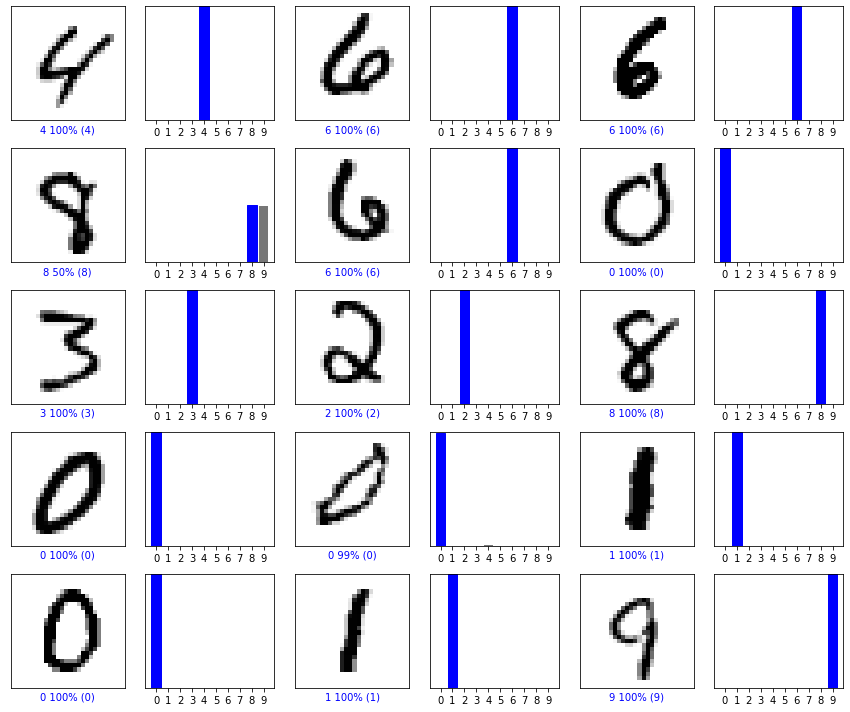

In [10]:
teacher_model_prob = tf.keras.Sequential([teacher_model, Softmax()])
predictions = teacher_model_prob.predict(x_test_selected)
plot_predictions(x_test_selected, y_test_selected, predictions)

## Train autodidact student

In [11]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()

student_model = student()
student_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train_selected, 
    y_train_selected, 
    test_size=0.3, 
    random_state=42)
student_model.fit(x_tr, 
                  y_tr, 
                  epochs=20, 
                  validation_data=[x_val, y_val],
                  callbacks=[tf.keras.callbacks.EarlyStopping()])

test_loss, auto_test_acc = student_model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print('\nTest accuracy:', auto_test_acc)

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 2s 41us/sample - loss: 0.5306 - accuracy: 0.8636 - val_loss: 0.3440 - val_accuracy: 0.9062
Epoch 2/20
42000/42000 [==============================] - 1s 36us/sample - loss: 0.3227 - accuracy: 0.9100 - val_loss: 0.3047 - val_accuracy: 0.9162
Epoch 3/20
42000/42000 [==============================] - 1s 36us/sample - loss: 0.2950 - accuracy: 0.9173 - val_loss: 0.2907 - val_accuracy: 0.9191
Epoch 4/20
42000/42000 [==============================] - 1s 36us/sample - loss: 0.2816 - accuracy: 0.9215 - val_loss: 0.2831 - val_accuracy: 0.9218
Epoch 5/20
42000/42000 [==============================] - 2s 37us/sample - loss: 0.2729 - accuracy: 0.9241 - val_loss: 0.2826 - val_accuracy: 0.9227
Epoch 6/20
42000/42000 [==============================] - 1s 36us/sample - loss: 0.2673 - accuracy: 0.9250 - val_loss: 0.2792 - val_accuracy: 0.9234
Epoch 7/20
42000/42000 [==============================] 

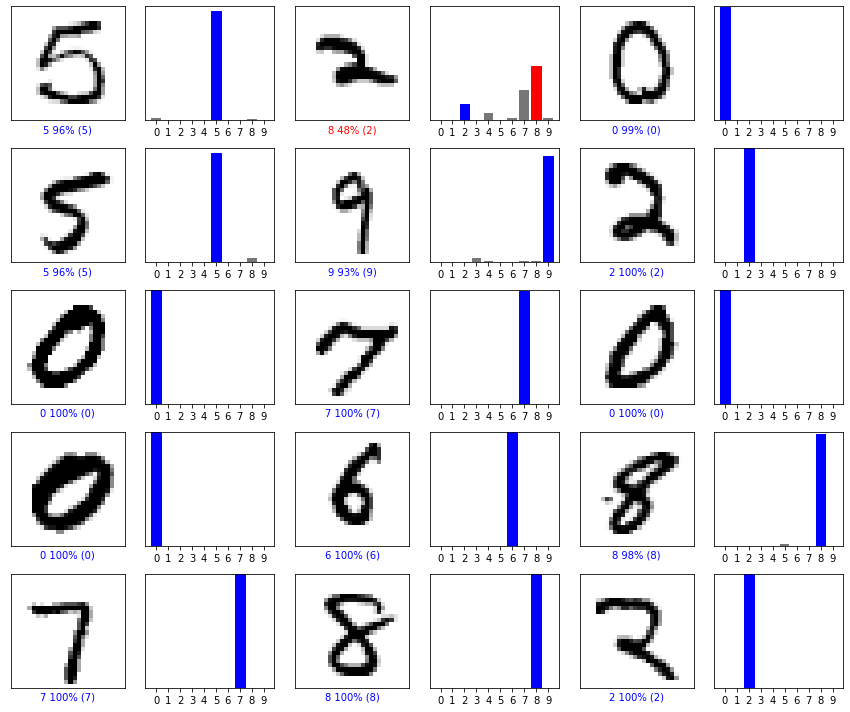

In [12]:
student_model_prob = tf.keras.Sequential([student_model, Softmax()])
predictions = student_model_prob.predict(x_test_selected)

plot_predictions(x_test_selected, y_test_selected, predictions)

## Episode: Softmax with temperature

\begin{equation*}
softmax(\mathbf{z})_c = \frac{e^{z_c}}{\sum_{d=1}^K e^{z_d}} \quad \text{for} \; c = 1 
\cdots K
\end{equation*}

\begin{equation*}
softmax(\mathbf{z}, T)_c = \frac{e^{\frac{z_c}{T}}}{\sum_{d=1}^K e^{\frac{z_d}{T}}} \quad \text{for} \; c = 1 \cdots K 
\end{equation*}

In [13]:
class TemperatureScale(tf.keras.layers.Layer):
    def __init__(self, t=1, **kwargs):
        super(TemperatureScale, self).__init__(**kwargs)
        self.t = t
    
    def call(self, inputs):
        return tf.divide(inputs, self.t)

In [14]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()

teacher_model_prob = tf.keras.Sequential([teacher_model, 
                                          TemperatureScale(t=1),
                                          Softmax()])
teacher_predictions_1 = teacher_model_prob.predict(tf.expand_dims(x_train_selected[0], axis=0))

teacher_model_prob = tf.keras.Sequential([teacher_model, 
                                          TemperatureScale(t=5),
                                          Softmax()])
teacher_predictions_5 = teacher_model_prob.predict(tf.expand_dims(x_train_selected[0], axis=0))

teacher_model_prob = tf.keras.Sequential([teacher_model, 
                                          TemperatureScale(t=10),
                                          Softmax()])
teacher_predictions_10 = teacher_model_prob.predict(tf.expand_dims(x_train_selected[0], axis=0))

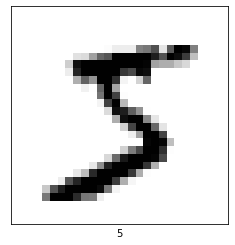

In [15]:
plot_image(x_train_selected[0], y_train_selected[0])
plt.show()

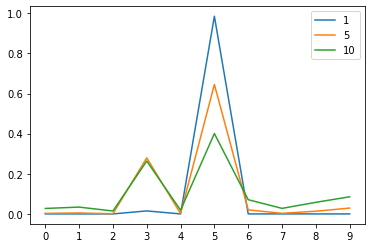

In [16]:
plt.plot(teacher_predictions_1[0])
plt.plot(teacher_predictions_5[0])
plt.plot(teacher_predictions_10[0])
plt.legend([1, 5, 10])
plt.xticks(range(10))
plt.show()

## Distill the dark knowledge

In [17]:
T = 1.2
teacher_model_prob = tf.keras.Sequential([teacher_model, TemperatureScale(t=T), Softmax()])
teacher_predictions = teacher_model_prob.predict(x_train_selected)

In [18]:
student_model = student()
student_model_T = tf.keras.Sequential([student_model, TemperatureScale(t=T)])
student_model_T.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                      metrics=['accuracy'])

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train_selected, 
    teacher_predictions, 
    test_size=0.3, 
    random_state=42)
student_model_T.fit(x_tr,
                  y_tr, 
                  epochs=20, 
                  validation_data=[x_val, y_val], 
                  callbacks=[tf.keras.callbacks.EarlyStopping()])

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 2s 43us/sample - loss: 0.5629 - accuracy: 0.8588 - val_loss: 0.3446 - val_accuracy: 0.9094
Epoch 2/20
42000/42000 [==============================] - 2s 37us/sample - loss: 0.3334 - accuracy: 0.9088 - val_loss: 0.2972 - val_accuracy: 0.9214
Epoch 3/20
42000/42000 [==============================] - 2s 38us/sample - loss: 0.3033 - accuracy: 0.9156 - val_loss: 0.2808 - val_accuracy: 0.9229
Epoch 4/20
42000/42000 [==============================] - 2s 38us/sample - loss: 0.2892 - accuracy: 0.9197 - val_loss: 0.2714 - val_accuracy: 0.9263
Epoch 5/20
42000/42000 [==============================] - 2s 39us/sample - loss: 0.2801 - accuracy: 0.9230 - val_loss: 0.2701 - val_accuracy: 0.9276
Epoch 6/20
42000/42000 [==============================] - 2s 38us/sample - loss: 0.2742 - accuracy: 0.9247 - val_loss: 0.2660 - val_accuracy: 0.9286
Epoch 7/20
42000/42000 [==============================] 

In [19]:
metrics = student_model_T.evaluate(x_test_selected,  
                                 tf.one_hot(y_test_selected, depth=10),
                                 verbose=2)
test_loss, test_acc = metrics
print(f'\nDistilled test accuracy: {test_acc:.4f} (vs autodidact: {auto_test_acc:.4f}, teacher: {teacher_test_acc:.4f})')

10000/10000 - 0s - loss: 0.2702 - accuracy: 0.9244

Distilled test accuracy: 0.9244 (vs autodidact: 0.9239, teacher: 0.9851)


In [20]:
student_model_prob = tf.keras.Sequential([student_model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)

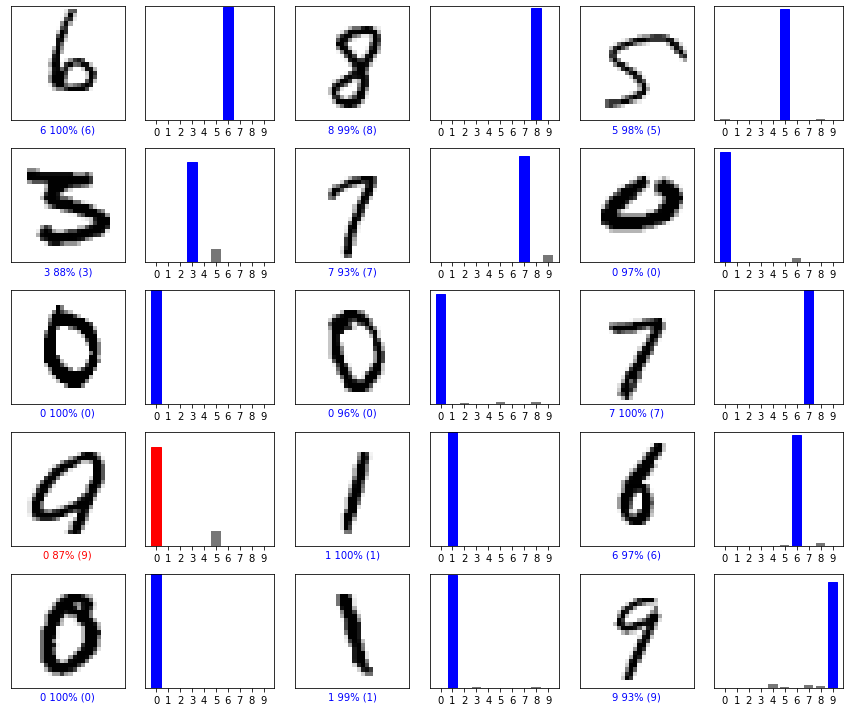

In [21]:
plot_predictions(x_test_selected, y_test_selected, predictions)

In [22]:
print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.88      0.91      1032
           3       0.88      0.93      0.90      1010
           4       0.92      0.95      0.93       982
           5       0.93      0.85      0.88       892
           6       0.93      0.96      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.87      0.89      0.88       974
           9       0.92      0.91      0.92      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## Moral #1:

Those who can, do; those who can't, teach. But it's ok.

# Training on limited data

In [24]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits([0, 1, 2, 5])

student_model = student()
student_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

student_model.fit(x_train_selected, 
          y_train_selected, 
          epochs=20, 
          validation_split=0.3, 
          callbacks=[tf.keras.callbacks.EarlyStopping()])

test_loss, auto_test_acc = student_model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print('\nTest accuracy:', auto_test_acc)

Train on 16830 samples, validate on 7214 samples
Epoch 1/20
16830/16830 [==============================] - 1s 52us/sample - loss: 0.3288 - accuracy: 0.9223 - val_loss: 0.1467 - val_accuracy: 0.9608
Epoch 2/20
16830/16830 [==============================] - 1s 36us/sample - loss: 0.1326 - accuracy: 0.9641 - val_loss: 0.1128 - val_accuracy: 0.9685
Epoch 3/20
16830/16830 [==============================] - 1s 38us/sample - loss: 0.1097 - accuracy: 0.9679 - val_loss: 0.1026 - val_accuracy: 0.9706
Epoch 4/20
16830/16830 [==============================] - 1s 37us/sample - loss: 0.0987 - accuracy: 0.9708 - val_loss: 0.0922 - val_accuracy: 0.9728
Epoch 5/20
16830/16830 [==============================] - 1s 37us/sample - loss: 0.0908 - accuracy: 0.9734 - val_loss: 0.0888 - val_accuracy: 0.9728
Epoch 6/20
16830/16830 [==============================] - 1s 37us/sample - loss: 0.0855 - accuracy: 0.9746 - val_loss: 0.0883 - val_accuracy: 0.9744
Epoch 7/20
16830/16830 [==============================] -

In [25]:
student_model_prob = tf.keras.Sequential([student_model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)

print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.69      0.99      0.81       980
           1       0.61      0.99      0.76      1135
           2       0.30      0.97      0.46      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.25      0.95      0.39       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.40     10000
   macro avg       0.19      0.39      0.24     10000
weighted avg       0.19      0.40      0.25     10000



/Users/metuoku/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


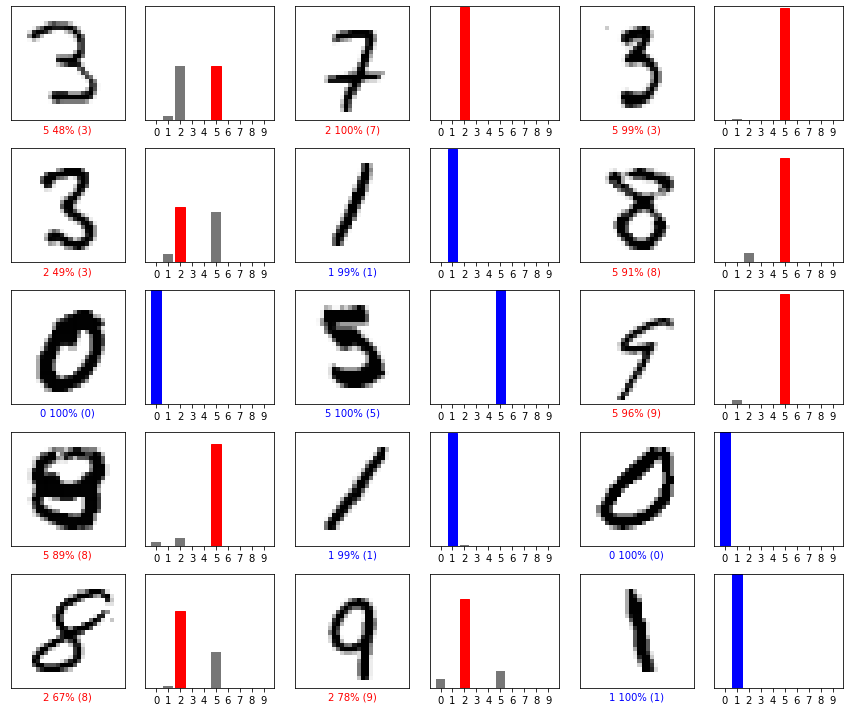

In [26]:
plot_predictions(x_test_selected, y_test_selected, predictions)

## Distillation on limited data

In [27]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits([0, 1, 2, 5])
T=100
teacher_model_prob = tf.keras.Sequential([teacher_model, TemperatureScale(t=T), Softmax()])
teacher_predictions = teacher_model_prob.predict(x_train_selected)

In [28]:
student_model = student()
student_model_T = tf.keras.Sequential([student_model, TemperatureScale(t=T)])
student_model_T.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

student_model_T.fit(x_train_selected, 
          teacher_predictions, 
          epochs=20, 
          validation_split=0.3, 
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
                 verbose=0)

test_loss, test_acc = student_model_T.evaluate(x_test_selected,  
                                               tf.one_hot(y_test_selected, depth=10), 
                                               verbose=2)
print(f'\nTest accuracy: {test_acc:.4f} (vs {auto_test_acc:.4f})')

10000/10000 - 0s - loss: 2.2087 - accuracy: 0.5356

Test accuracy: 0.5356 (vs 0.3953)


In [29]:
student_model_prob = tf.keras.Sequential([student_model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)

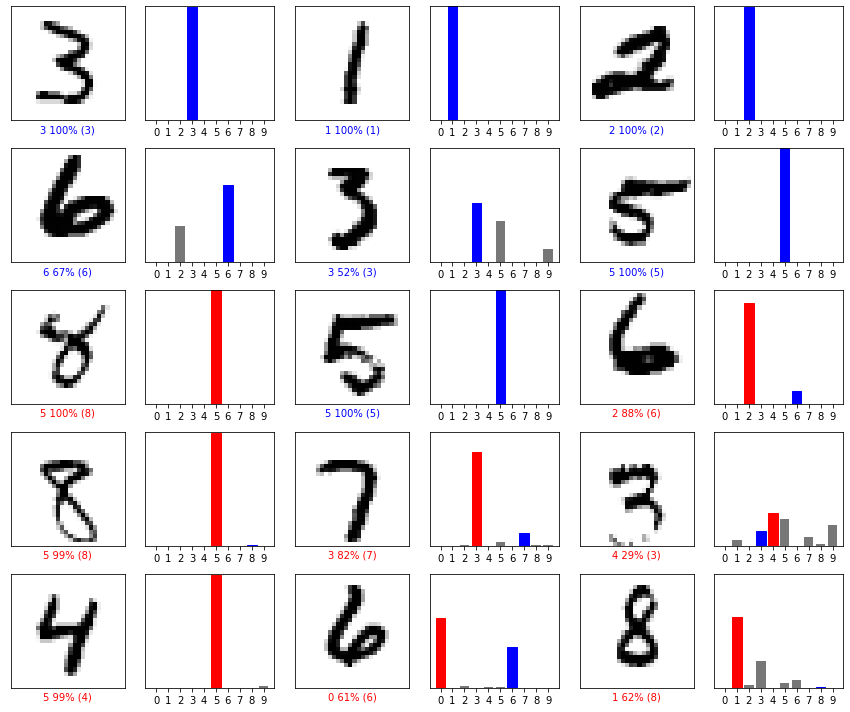

In [32]:
plot_predictions(x_test_selected, y_test_selected, predictions)

In [33]:
print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       980
           1       0.73      0.98      0.84      1135
           2       0.55      0.86      0.67      1032
           3       0.55      0.44      0.49      1010
           4       0.84      0.14      0.24       982
           5       0.24      0.93      0.39       892
           6       0.97      0.25      0.40       958
           7       0.90      0.26      0.40      1028
           8       0.66      0.31      0.42       974
           9       0.47      0.19      0.27      1009

    accuracy                           0.54     10000
   macro avg       0.68      0.53      0.50     10000
weighted avg       0.68      0.54      0.51     10000



## Moral #2:

An experienced teacher might teach you more than the subject itself.

# Federated learning

In [34]:
def average_weights(models):
    w = models[0].get_weights()
    for i in range(1, len(models)):
        w_i = models[i].get_weights()
        for j in range(len(w)):
            w[j] += w_i[j]

    for j in range(len(w)):
        w[j] /= len(models)

    for m in models:
        m.set_weights(w)

In [35]:
models = []
for i in range(3):
    model = student()

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    models.append(model)

In [36]:
datasets = [
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8, 9],
]

In [37]:
rounds = 50
local_epochs = 1
for r in range(rounds):
    print(f'round {r}')
    for m, d in zip(models, datasets):
        (x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits(d)

        m.fit(x_train_selected, 
              y_train_selected, 
              epochs=local_epochs,
             verbose=0)
    test_loss, auto_test_acc = models[0].evaluate(x_test_selected,  y_test_selected, verbose=2)
    average_weights(models)
    test_loss, auto_test_acc = models[0].evaluate(x_test_selected,  y_test_selected, verbose=2)

round 0
10000/10000 - 0s - loss: 4.2847 - accuracy: 0.3070
10000/10000 - 0s - loss: 1.4561 - accuracy: 0.7435
round 1
10000/10000 - 0s - loss: 3.3830 - accuracy: 0.3082
10000/10000 - 0s - loss: 1.0795 - accuracy: 0.8027
round 2
10000/10000 - 0s - loss: 2.8387 - accuracy: 0.3104
10000/10000 - 0s - loss: 0.8883 - accuracy: 0.8220
round 3
10000/10000 - 0s - loss: 2.4719 - accuracy: 0.3306
10000/10000 - 0s - loss: 0.7766 - accuracy: 0.8328
round 4
10000/10000 - 0s - loss: 2.2125 - accuracy: 0.3620
10000/10000 - 0s - loss: 0.7036 - accuracy: 0.8410
round 5
10000/10000 - 0s - loss: 2.0201 - accuracy: 0.3942
10000/10000 - 0s - loss: 0.6518 - accuracy: 0.8479
round 6
10000/10000 - 0s - loss: 1.8714 - accuracy: 0.4229
10000/10000 - 0s - loss: 0.6131 - accuracy: 0.8532
round 7
10000/10000 - 0s - loss: 1.7527 - accuracy: 0.4462
10000/10000 - 0s - loss: 0.5828 - accuracy: 0.8563
round 8
10000/10000 - 0s - loss: 1.6554 - accuracy: 0.4668
10000/10000 - 0s - loss: 0.5584 - accuracy: 0.8602
round 9
10

In [41]:
model = models[0]

In [42]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()
test_loss, auto_test_acc = model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print(f'\nTest accuracy:', auto_test_acc)

10000/10000 - 0s - loss: 0.3639 - accuracy: 0.8992

Test accuracy: 0.8992


In [43]:
student_model_prob = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits(dataset)
print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.94      0.98      0.96      1135
           2       0.91      0.84      0.87      1032
           3       0.87      0.91      0.89      1010
           4       0.87      0.92      0.90       982
           5       0.86      0.85      0.85       892
           6       0.91      0.93      0.92       958
           7       0.90      0.92      0.91      1028
           8       0.88      0.80      0.84       974
           9       0.89      0.86      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Moral #3:

Where we're going, we don't need teachers!

# Stuff to read

#### Knowledge distillation
https://arxiv.org/abs/1503.02531
#### Federated learning
https://arxiv.org/abs/1602.05629

#### Tensorflow
https://www.tensorflow.org/tutorials